# Birdsong Clustering with Mel-spectrograms
- Algorithm:  Agglomerative clustering
- Features:  Mel-spectrograms
- Models:  Gaussian mixture models
- Ref:  Ajmera et al., [Robust Audio Segmentation](https://infoscience.epfl.ch/record/83070/files/rr04-35.pdf), 2004

This notebook applies a speaker diarization algorithm to soundscape recordings.
That is, instead of splitting up the audio according to when each person is speaking, the audio should be split according to which bird is singing.
This would have some of the same complications that speaker diarization has:
- Overlapping speakers/birds
- Background noise (e.g., airplanes)

Mel-spectrogram features are used here.  While they may not be the optimal choice, they are a relatively simple starting point.  Alternative methods for feature extraction include:
- Cepstral coefficients
- i-vectors (Dehak, [Discriminative and generative approaches for long- and short-term speaker characteristics modeling : application to speaker verification](https://espace.etsmtl.ca/id/eprint/33), 2009)
- Neural networks (e.g., d-vectors: Variani et al. [Deep neural networks for small footprint text-dependent speaker verification](https://doi.org/10.1109/ICASSP.2014.6854363), 2014)

This notebook performs "bird diarization" on four minutes of audio, recorded with a Zoom H2n Handy recorder.  The audio is divided into eight second segments to initialize 30 different Gaussian mixture models (GMMs).  The algorithm then iterates as follows:
- Segment the audio using the Viterbi algorithm and the GMMs.
- Retrain the GMMs using the segmentation.
- Identify the pair of GMMs whose merger would give the largest increase in likelihood.  If there is no pair that would increase the likelihood, then stop.

Samples from the resulting clusters are provided in spectrograms near the bottom and in separate WAV files.

In [ ]:
import sys
!apt update
!apt install -y libsndfile1
!{sys.executable} -m pip install librosa

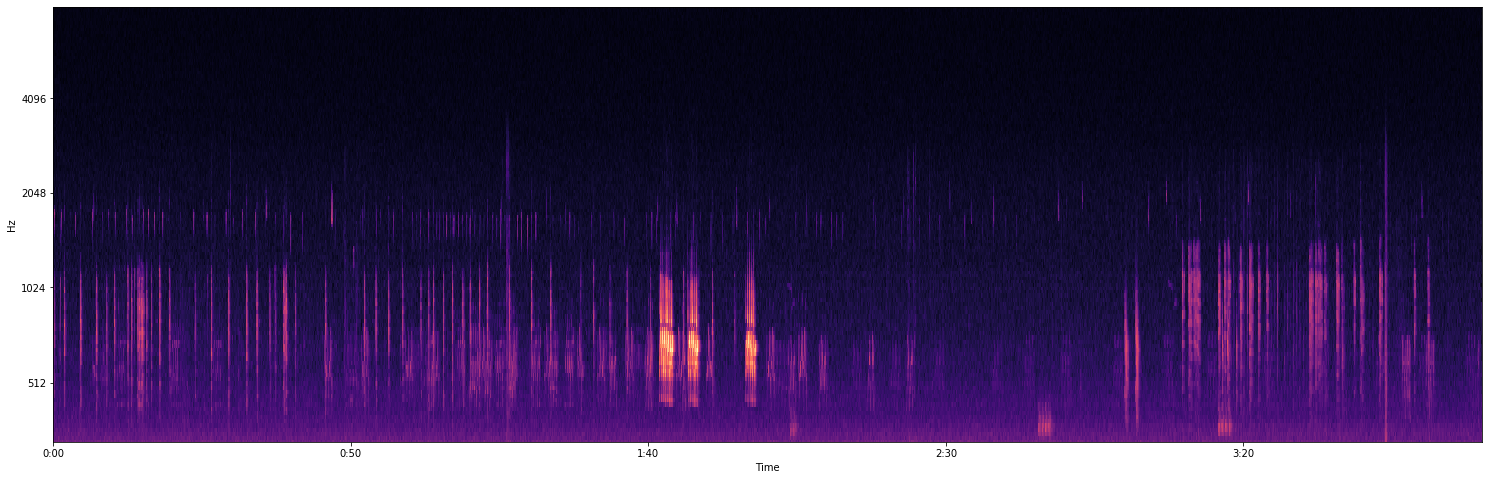

In [1]:
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf

from utils import preprocessing
from clustering import agglomerative

n_mels = 128
fmin = 200
fmax = 8000
file_base = '201203-063632_064032'
audio, sr = preprocessing.load_audio('toddstephenson', f'H2N/{file_base}.WAV')
spec, hop_length = preprocessing.compute_spec(audio, sr, n_mels=n_mels, fmin=fmin, fmax=fmax)
cmap = librosa.display.cmap(spec)

# https://stackoverflow.com/questions/14770735/how-do-i-change-the-figure-size-with-subplots
fig, ax = plt.subplots(1, 1, figsize=(spec.shape[1]/5., 8))

# NOTE:  There appears to be a bug in specshow that incorrectly labels the frequencies on the y-axis.
# See https://github.com/librosa/librosa/issues/1240
librosa.display.specshow(spec.T, y_axis='mel', x_axis='time', sr=sr, ax=ax,
                         hop_length=hop_length, fmin=fmin, fmax=fmax, cmap=cmap);

Found 0 frames for model 14.  Pruning. . . .
Found 0 frames for model 2.  Pruning. . . .
best_pair: (1, 7)
best_pair: (1, 11)
best_pair: (20, 22)
best_pair: (1, 8)
best_pair: (0, 1)
best_pair: (5, 13)
best_pair: (6, 18)
best_pair: (0, 7)
best_pair: (0, 17)
best_pair: (7, 17)
best_pair: (0, 6)
best_pair: (0, 9)
best_pair: (0, 9)
best_pair: (0, 1)
best_pair: (0, 3)
best_pair: (3, 8)
best_pair: (0, 8)
best_pair: (0, 5)
best_pair: (0, 8)
best_pair: (3, 8)
best_pair: (1, 7)
best_pair: (0, 1)
best_pair: (0, 4)
best_pair: (0, 1)


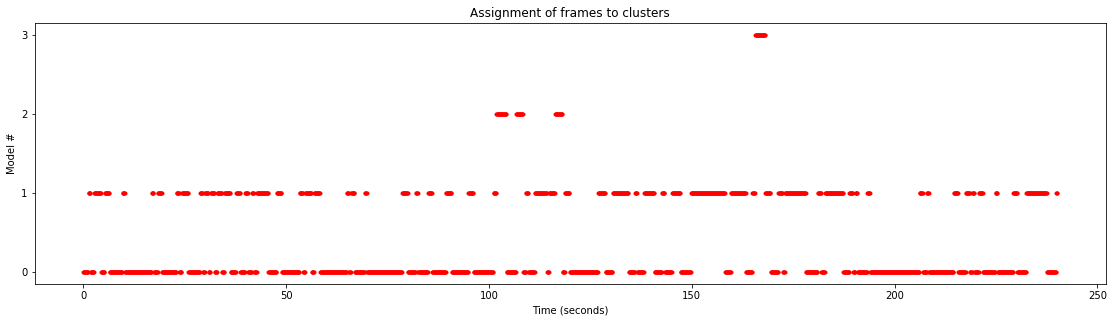

In [2]:
num_initial_clusters = 30
models = agglomerative.init_models(spec, num_initial_clusters, num_components=1)
fig, axs = plt.subplots(1, 1, figsize=(3*6.4, 1*4.8))
for i in range(num_initial_clusters-1):
    good_segmentation = False
    while not good_segmentation:
        states = agglomerative.decode_states(spec, models)
        pruned_models = agglomerative.prune(models, states)
        if len(pruned_models) == len(models):
            good_segmentation = True
        else:
            models = pruned_models
    models = agglomerative.fit_models(spec, models, states)
    models, did_merge = agglomerative.merge(spec, models, states)
    if not did_merge:
        break

axs.plot(np.linspace(0, len(states)*hop_length/sr, num=len(states)), states, 'r.');
axs.set_xlabel('Time (seconds)')
axs.set_ylabel('Model #')
axs.set_yticks(range(0, len(models)))
axs.set(title='Assignment of frames to clusters');

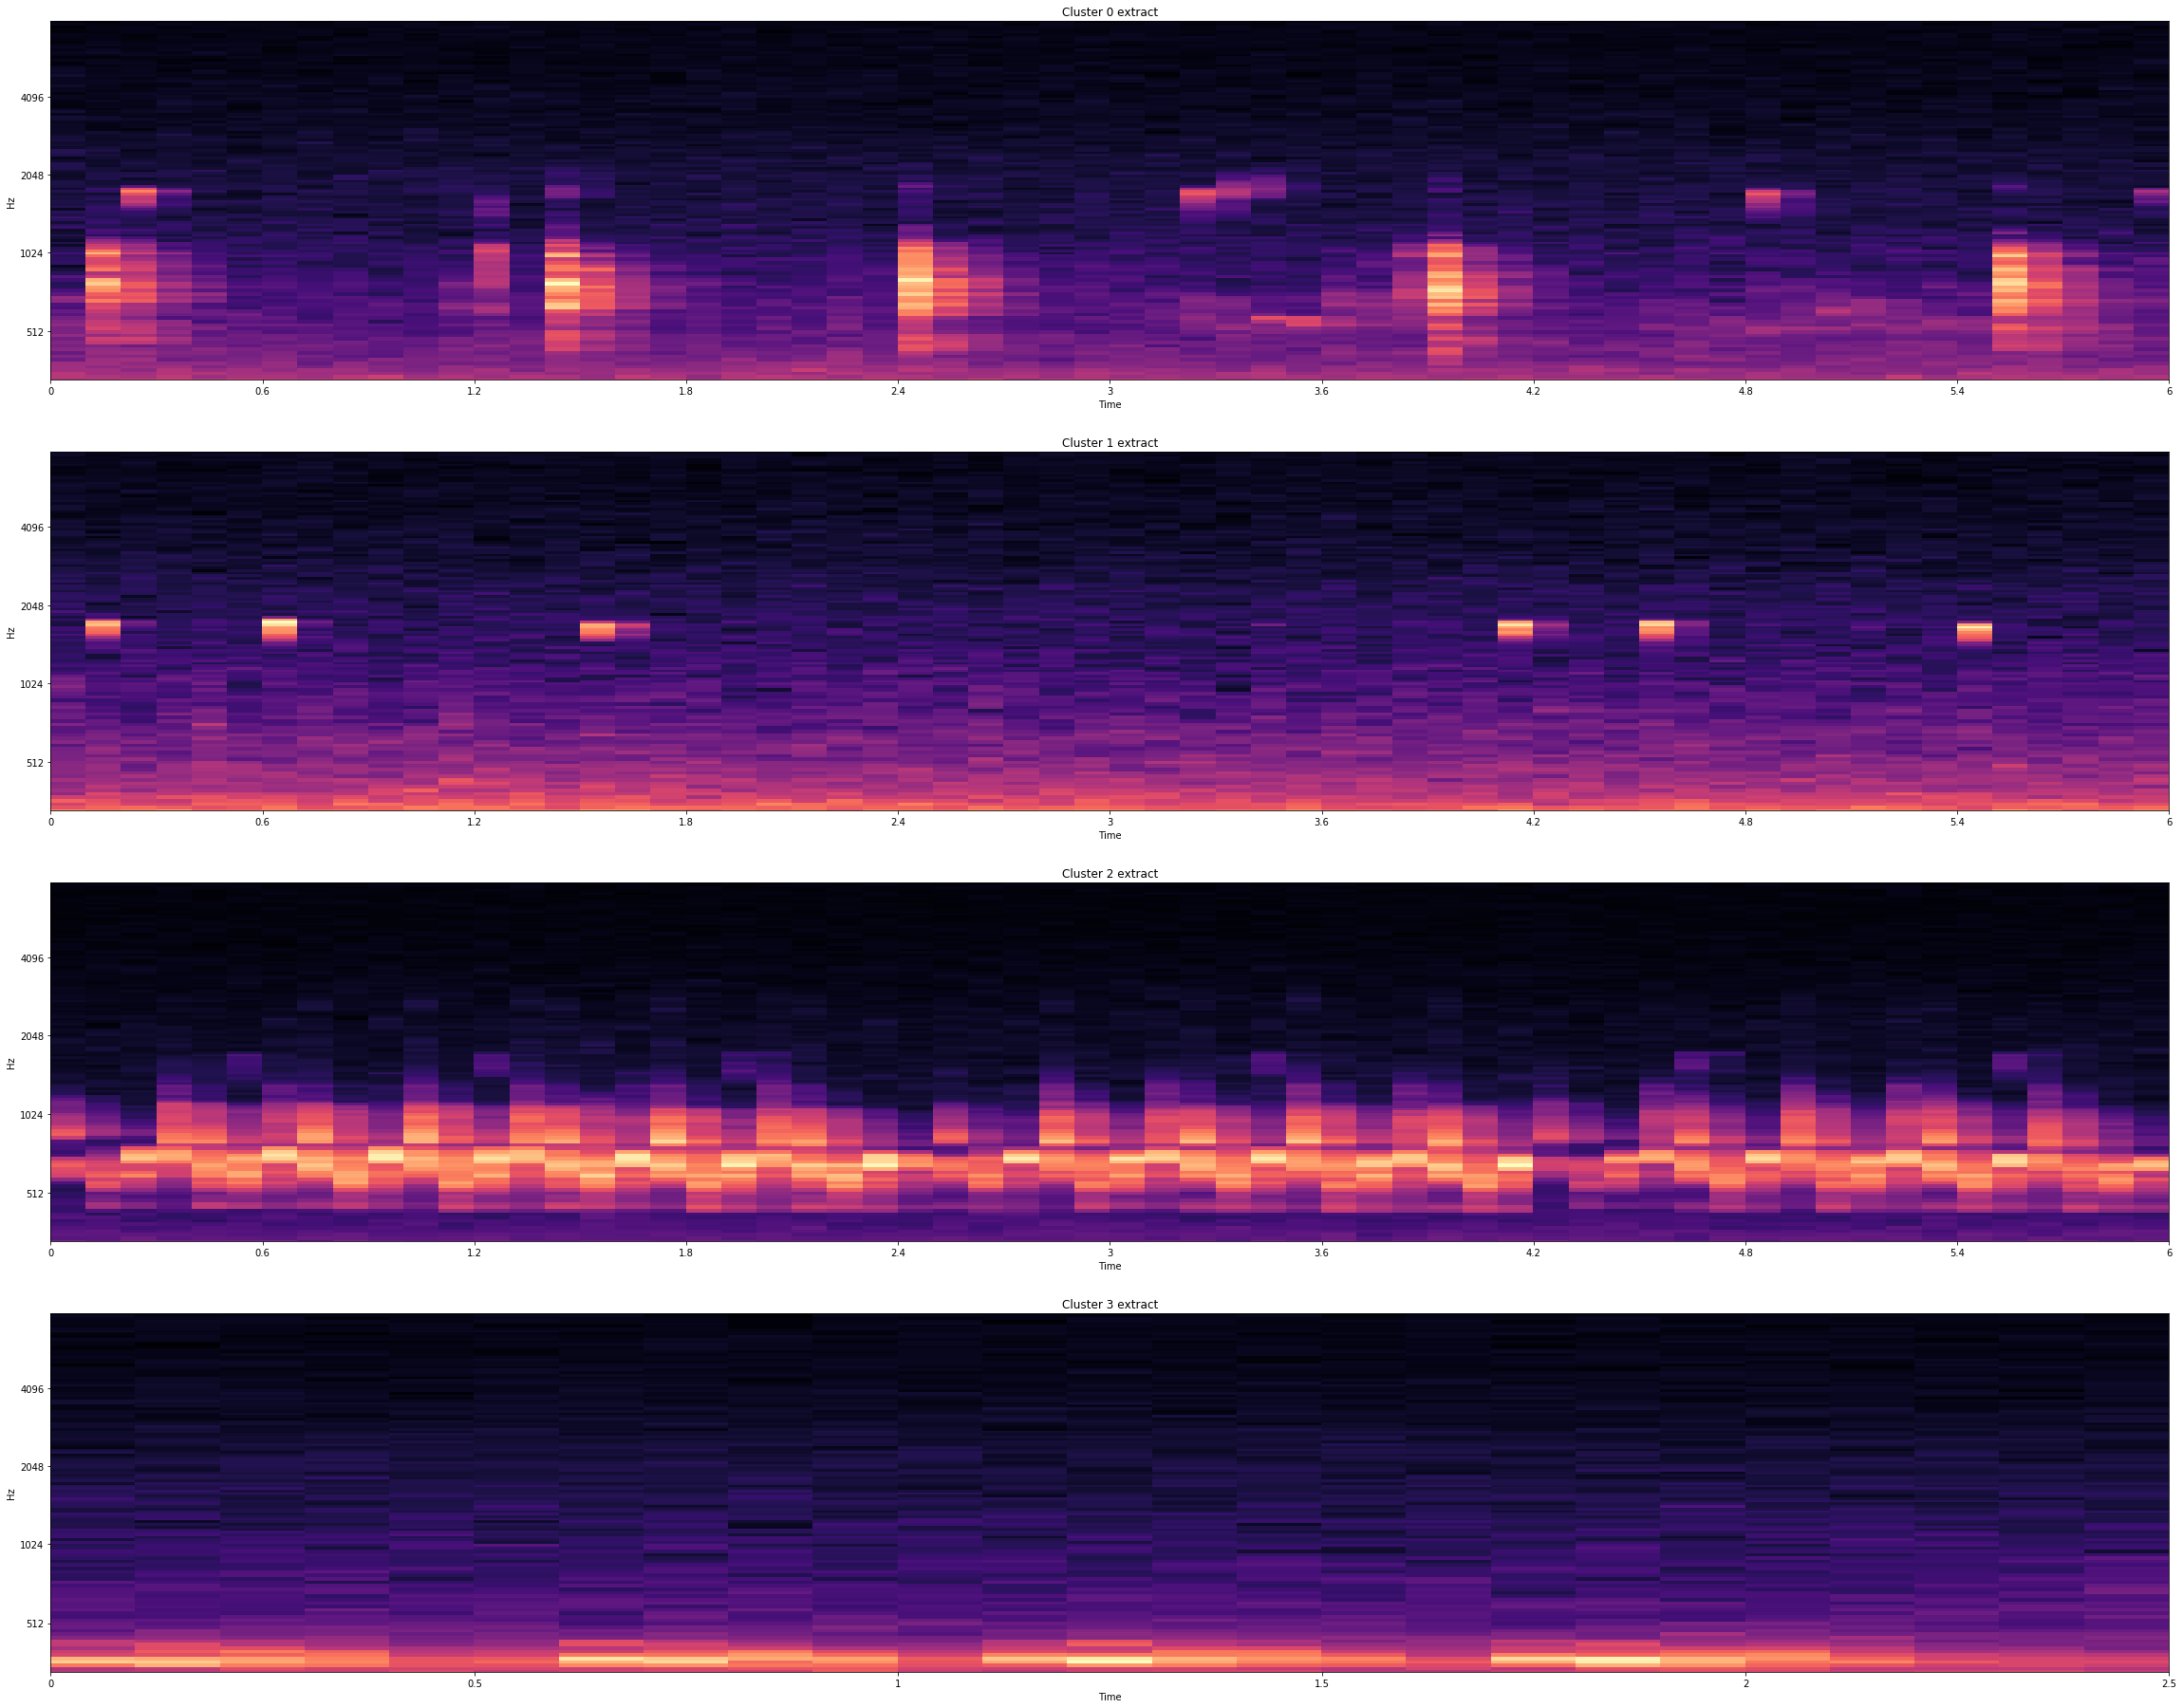

In [3]:
sample_states = np.repeat(states, hop_length)[:len(audio)]
sample_audio = []
fig, ax = plt.subplots(len(models), 1, figsize=(40., len(models)*8))

num_secs = 6
extract_sr = 16000
for s in sorted(set(states)):
    extract = librosa.resample(audio[sample_states==s], sr, extract_sr)
    extract = extract[:num_secs*extract_sr]
    sf.write(f'{file_base}_melspec_cluster{s}.WAV', extract, extract_sr)
    sample_audio.append(extract)
    img = librosa.display.specshow(spec[states==s][:num_secs*sr//hop_length,:].T,
                                   y_axis='mel', x_axis='time', sr=sr, ax=ax[s],
                                   hop_length=hop_length, fmin=fmin, fmax=fmax, cmap=cmap)
    ax[s].set(title=f'Cluster {s} extract');

In [4]:
# ipd.Audio(sample_audio[0], rate=extract_sr)